In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
import traceback
import pickle

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [40]:

def calculate_win_loss(df):
    """승리여부를 계산하는 함수"""
    df = df.copy()
    df['경기ID'] = df.groupby(['날짜', '경기장']).ngroup()
    
    # 각 경기별로 승리팀 계산
    game_results = []
    for game_id in df['경기ID'].unique():
        game = df[df['경기ID'] == game_id].copy()
        if len(game) == 2:  # 두 팀의 데이터가 모두 있는 경우만
            game = game.sort_values('득점', ascending=False)
            game.iloc[0, game.columns.get_loc('승리여부')] = '승'
            game.iloc[1, game.columns.get_loc('승리여부')] = '패'
            game_results.append(game)
    
    return pd.concat(game_results)


In [41]:

def load_data(file_path='BASEBALL_stats_15.xlsx'):
    """데이터를 로드하고 기본 정보를 출력하는 함수"""
    logging.info("데이터 로드 시작...")
    try:
        df = pd.read_excel(file_path)
        df['승리여부'] = ''  # 승리여부 컬럼 추가
        df = calculate_win_loss(df)  # 승리여부 계산
        logging.info(f"데이터 로드 완료. 데이터 크기: {df.shape}")
        return df
    except Exception as e:
        logging.error(f"데이터 로드 중 오류 발생: {str(e)}")
        raise


In [42]:

def create_advanced_features(df):
    """고급 특성 생성 함수"""
    # 팀 성적 관련 특성
    df['득점률'] = df['득점'] / df['타수']
    df['출루율'] = (df['안타'] + df['볼넷'] + df['사구']) / (df['타수'] + df['볼넷'] + df['사구'])
    
    # 경기장 특성
    stadium_stats = df.groupby('경기장').agg({
        '득점': 'mean',
        '안타': 'mean',
        '홈런': 'mean'
    }).reset_index()
    
    stadium_stats.columns = ['경기장', '경기장_평균득점', '경기장_평균안타', '경기장_평균홈런']
    df = df.merge(stadium_stats, on='경기장', how='left')
    
    return df



In [43]:
def calculate_team_stats(df, target_date, window=10):
    """팀별 이동평균 통계를 계산하는 함수"""
    logging.info(f"팀 통계 계산 중 (기준일: {target_date}, window={window})...")
    stats_list = []
    
    for team in df['팀명'].unique():
        # 해당 날짜 이전의 데이터만 선택
        team_data = df[
            (df['팀명'] == team) & 
            (df['날짜'] < target_date)
        ].sort_values('날짜')
        
        # 데이터가 충분하지 않은 경우 처리
        if len(team_data) < 1:
            continue
        
        # 기본 통계
        recent_stats = pd.DataFrame({
            '최근승률': team_data['승리여부'].eq('승').rolling(window, min_periods=1).mean().iloc[-1],
            '최근평균득점': team_data['득점'].rolling(window, min_periods=1).mean().iloc[-1],
            '최근평균안타': team_data['안타'].rolling(window, min_periods=1).mean().iloc[-1],
            '최근평균홈런': team_data['홈런'].rolling(window, min_periods=1).mean().iloc[-1],
            '최근평균타율': (
                team_data['안타'].rolling(window, min_periods=1).sum() /
                team_data['타수'].rolling(window, min_periods=1).sum()
            ).iloc[-1],
            '최근평균출루율': (
                (team_data['안타'] + team_data['볼넷'] + team_data['사구']).rolling(window, min_periods=1).sum() /
                (team_data['타수'] + team_data['볼넷'] + team_data['사구']).rolling(window, min_periods=1).sum()
            ).iloc[-1]
        }, index=[0])
        
        recent_stats['팀명'] = team
        recent_stats['날짜'] = target_date
        stats_list.append(recent_stats)
    
    if not stats_list:
        return pd.DataFrame()
    
    return pd.concat(stats_list, ignore_index=True)


In [44]:

def create_base_models():
    """기본 모델들을 생성하는 함수"""
    models = {
        'xgb': xgb.XGBClassifier(
            learning_rate=0.02,
            max_depth=4,
            n_estimators=200,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        ),
        'lgb': lgb.LGBMClassifier(
            learning_rate=0.02,
            max_depth=4,
            n_estimators=200,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        ),
        'rf': RandomForestClassifier(
            n_estimators=200,
            max_depth=4,
            min_samples_split=5,
            random_state=42
        )
    }
    return models



In [45]:
def create_stacking_classifier(base_models):
    """스태킹 앙상블 모델을 생성하는 함수"""
    meta_model = LogisticRegression(random_state=42)
    
    # KFold 교차 검증 설정
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    return StackingClassifier(
        estimators=list(base_models.items()),
        final_estimator=meta_model,
        cv=cv,
        n_jobs=-1,  # 병렬 처리 활성화
        passthrough=True  # 원본 특성도 메타 모델에 전달
    )



In [46]:
def preprocess_data(df):
    """데이터 전처리를 수행하는 함수"""
    logging.info("데이터 전처리 시작...")
    
    # 날짜 변환
    df['날짜'] = pd.to_datetime(df['날짜'])
    df = df.sort_values('날짜')
    
    # 고급 특성 생성
    df = create_advanced_features(df)
    
    # 각 날짜별로 통계 계산
    processed_data = []
    for date in df['날짜'].unique():
        # 해당 날짜의 경기 데이터
        current_games = df[df['날짜'] == date]
        
        # 해당 날짜 이전 데이터로 통계 계산
        team_stats = calculate_team_stats(df, date)
        
        # 현재 경기 데이터와 통계 병합
        if not team_stats.empty:
            current_games = current_games.merge(
                team_stats, on=['팀명', '날짜'], how='left')
        
        processed_data.append(current_games)
    
    # 모든 처리된 데이터 합치기
    df_processed = pd.concat(processed_data, ignore_index=True)
    
    # 범주형 변수 인코딩
    le = LabelEncoder()
    categorical_columns = ['팀명', '경기장', '홈/원정']
    
    for col in categorical_columns:
        df_processed[col + '_인코딩'] = le.fit_transform(df_processed[col])
    
    # 결측치가 있는 행 제거
    df_processed = df_processed.dropna()
    
    return df_processed


In [47]:

def main():
    try:
        # 1. 데이터 로드
        df = load_data()
        
        # 2. 데이터 전처리
        df = preprocess_data(df)
        
        # 3. 특성 선택
        features = [
            '팀명_인코딩', '경기장_인코딩', '홈/원정_인코딩',
            '최근승률', '최근평균득점', '최근평균안타', '최근평균홈런',
            '최근평균타율', '최근평균출루율', '득점률', '출루율'
        ]
        
        # 4. 데이터 분할
        X = df[features]
        y = (df['승리여부'] == '승').astype(int)
        
        # 시계열 분할
        tscv = TimeSeriesSplit(n_splits=5)
        splits = list(tscv.split(X))
        train_index, test_index = splits[-1]
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # 5. 전처리 파이프라인 생성
        preprocessing = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        
        # 6. 데이터 전처리 적용
        X_train_processed = preprocessing.fit_transform(X_train)
        X_test_processed = preprocessing.transform(X_test)

        with open('./Model_5_preprocessed_Data/X_train_processed.pickle',"wb") as f:
            pickle.dump(X_train_processed, f)
        with open('./Model_5_preprocessed_Data/X_test_processed.pickle',"wb") as f:
            pickle.dump(X_test_processed, f)
        with open('./Model_5_preprocessed_Data/y_train.pickle',"wb") as f:
            pickle.dump(y_train, f)
        with open('./Model_5_preprocessed_Data/y_test.pickle',"wb") as f:
            pickle.dump(y_test, f)
        
        # 7. 기본 모델 생성
        base_models = create_base_models()
        
        # 8. 스태킹 모델 생성 및 학습
        stacking_model = create_stacking_classifier(base_models)
        
        # 9. 모델 학습 (교차 검증 결과 출력)
        logging.info("\n기본 모델 학습 중...")
        for name, model in base_models.items():
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)
            accuracy = accuracy_score(y_test, y_pred)
            logging.info(f"{name} 모델 정확도: {accuracy:.4f}")
        
        logging.info("\n스태킹 모델 학습 중...")
        stacking_model.fit(X_train_processed, y_train)
        
        # 10. 예측 및 평가
        y_pred_proba = stacking_model.predict_proba(X_test_processed)[:, 1]
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        logging.info(f'\n스태킹 모델 정확도: {accuracy:.4f}')
        logging.info(f'스태킹 모델 AUC: {auc:.4f}')
        
        # 11. 결과 저장
        results = pd.DataFrame({
            '실제값': y_test,
            '예측값': y_pred,
            '예측확률': y_pred_proba
        })
        results.to_csv('prediction_results_stacking.csv', index=False, encoding='utf-8-sig')
        
        logging.info("\n모든 과정이 완료되었습니다.")
        
    except Exception as e:
        logging.error(f"\n오류 발생: {str(e)}")
        logging.error("\n상세 오류 정보:")
        logging.error(traceback.format_exc())



In [48]:
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 데이터 준비 (기존과 동일)
df = load_data()
df = preprocess_data(df)

features = [
    '팀명_인코딩', '경기장_인코딩', '홈/원정_인코딩',
    '최근승률', '최근평균득점', '최근평균안타', '최근평균홈런',
    '최근평균타율', '최근평균출루율', '득점률', '출루율'
]

X = df[features]
y = (df['승리여부'] == '승').astype(int)

# 전처리 파이프라인
preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 시계열 분할 및 반복 학습
tscv = TimeSeriesSplit(n_splits=100)
accuracies = []

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 전처리
    X_train_processed = preprocessing.fit_transform(X_train)
    X_test_processed = preprocessing.transform(X_test)

    # 모델 학습 및 평가
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Split {i+1}: Accuracy = {acc:.4f}")

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-')
plt.title("Split별 정확도 추이 (TimeSeriesSplit)")
plt.xlabel("Split 번호 (시간 순서)")
plt.ylabel("Accuracy")
plt.xticks(range(1, len(accuracies) + 1))
plt.grid(True)
plt.show()
'''

'\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.model_selection import TimeSeriesSplit\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import accuracy_score\n\n# 데이터 준비 (기존과 동일)\ndf = load_data()\ndf = preprocess_data(df)\n\nfeatures = [\n    \'팀명_인코딩\', \'경기장_인코딩\', \'홈/원정_인코딩\',\n    \'최근승률\', \'최근평균득점\', \'최근평균안타\', \'최근평균홈런\',\n    \'최근평균타율\', \'최근평균출루율\', \'득점률\', \'출루율\'\n]\n\nX = df[features]\ny = (df[\'승리여부\'] == \'승\').astype(int)\n\n# 전처리 파이프라인\npreprocessing = Pipeline([\n    (\'imputer\', SimpleImputer(strategy=\'mean\')),\n    (\'scaler\', StandardScaler())\n])\n\n# 시계열 분할 및 반복 학습\ntscv = TimeSeriesSplit(n_splits=100)\naccuracies = []\n\nfor i, (train_index, test_index) in enumerate(tscv.split(X)):\n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_

In [49]:
X_train

,팀명_인코딩,경기장_인코딩,홈/원정_인코딩,최근승률,최근평균득점,최근평균안타,최근평균홈런,최근평균타율,최근평균출루율,득점률,출루율
10,3,11,0,0.0,4.0,9.0,0.0,0.290323,0.388889,0.027778,0.289474
11,7,11,1,1.0,9.0,12.0,2.0,0.342857,0.425000,0.137931,0.241379
12,2,1,0,0.0,1.0,7.0,0.0,0.241379,0.333333,0.153846,0.428571
13,0,1,1,1.0,3.0,8.0,1.0,0.266667,0.333333,0.233333,0.432432
14,1,8,0,0.0,9.0,14.0,2.0,0.400000,0.522727,0.117647,0.315789
...,...,...,...,...,...,...,...,...,...,...,...
13906,9,2,1,0.6,5.2,8.2,1.4,0.239067,0.323834,0.166667,0.303030
13907,8,2,0,0.6,5.9,10.1,1.3,0.282913,0.356784,0.030303,0.257143
13908,7,2,0,0.3,4.7,7.1,0.8,0.208824,0.292105,0.100000,0.361111
13909,9,2,1,0.6,5.4,8.1,1.8,0.236152,0.315927,0.200000,0.450000


In [ ]:
'''
# 데이터 준비
df = load_data()
df = preprocess_data(df)

with open('./Model_5_preprocessed_Data/df.pickle',"wb") as f:
    pickle.dump(df, f)
'''

Split 1: Accuracy = 0.7775
Split 2: Accuracy = 0.7948
Split 3: Accuracy = 0.7646
Split 4: Accuracy = 0.7559
Split 5: Accuracy = 0.7473
Split 6: Accuracy = 0.7797
Split 7: Accuracy = 0.7970
Split 8: Accuracy = 0.7495
Split 9: Accuracy = 0.7711
Split 10: Accuracy = 0.7775
Split 11: Accuracy = 0.7797
Split 12: Accuracy = 0.7581
Split 13: Accuracy = 0.7343
Split 14: Accuracy = 0.8229
Split 15: Accuracy = 0.7646
Split 16: Accuracy = 0.7689
Split 17: Accuracy = 0.7970
Split 18: Accuracy = 0.7646
Split 19: Accuracy = 0.8056
Split 20: Accuracy = 0.7667
Split 21: Accuracy = 0.7775
Split 22: Accuracy = 0.7538
Split 23: Accuracy = 0.7559
Split 24: Accuracy = 0.7711
Split 25: Accuracy = 0.7927
Split 26: Accuracy = 0.7840
Split 27: Accuracy = 0.7819
Split 28: Accuracy = 0.7862
Split 29: Accuracy = 0.7797
Split 30: Accuracy = 0.7797


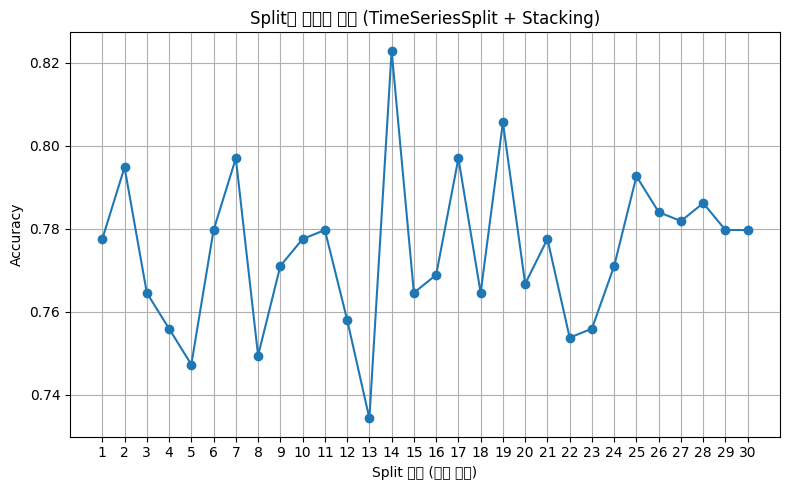

In [51]:
with open('./Model_5_preprocessed_Data/df.pickle',"rb") as f:
    df = pickle.load(f)

features = [
    '팀명_인코딩', '경기장_인코딩', '홈/원정_인코딩',
    '최근승률', '최근평균득점', '최근평균안타', '최근평균홈런',
    '최근평균타율', '최근평균출루율', '득점률', '출루율'
]

X = df[features]
y = (df['승리여부'] == '승').astype(int)

# 전처리 파이프라인
preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 시계열 분할 및 반복 학습
tscv = TimeSeriesSplit(n_splits=30)
accuracies = []

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 전처리
    X_train_processed = preprocessing.fit_transform(X_train)
    X_test_processed = preprocessing.transform(X_test)

    # 스태킹 모델 준비
    base_models = create_base_models()
    stacking_model = create_stacking_classifier(base_models)

    # 모델 학습 및 평가
    stacking_model.fit(X_train_processed, y_train)
    y_pred = stacking_model.predict(X_test_processed)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Split {i+1}: Accuracy = {acc:.4f}")

# 정확도 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-')
plt.title("Split별 정확도 추이 (TimeSeriesSplit + Stacking)")
plt.xlabel("Split 번호 (시간 순서)")
plt.ylabel("Accuracy")
plt.xticks(range(1, len(accuracies) + 1, max(1, len(accuracies) // 20)))
plt.grid(True)
plt.tight_layout()
plt.show()
